In [1]:
# importing the dependencies modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The code will allow you to switch between the dark and light mode in graphs

from matplotlib import cycler
colors = cycler('color',['#669FEE','#66EE91','#9988DD','#EECC55','#88BB44','#FFBBBB'])
plt.rc('figure',facecolor='#313233')
plt.rc('axes',facecolor='#313233',edgecolor='None',axisbelow=True,grid=True,prop_cycle=colors,labelcolor='gray')

plt.rc('grid',color='#47a4a4') #, linestlye='solid')
plt.rc('xtick',color='gray')
plt.rc('ytick',direction='out',color='gray')
plt.rc('legend',facecolor='#313233',edgecolor='#313233')
plt.rc('text',color='#c9c9c9')

In [3]:
def rsi(value, neutral, window):
	"""

	Input:
	:param value: (type dataframe pandas): Entry values of the stock
	:param neutral:(float) Value of the neutrality, i.e No Action Zone
	:param window: (float) rolling period for RSI calculation

	Output: The function gives the returns of RSI strategy
	:return:
	"""
	# Print error is no Adj Close column is not present
	if "Adj Close" not in value.columns:
		ValueError("Error: No Adj Close column is present")

	value['rsi'] = ta.momentum.RSIIndicator(value['Adj Close'], window=window).rsi()

	"""Long Buy signal"""
	overbuy = 70
	neutral_buy = 50 + neutral

	# Put nan values for te signal long columns
	value['signal_long'] = np.nan
	value['yesterday_rsi'] = value['rsi'].shift(1)
	# We need to define open long signal (Rsi yes>55 and RSI today>55)
	value.loc[(value['rsi'] > neutral_buy) & (value['yesterday_rsi'] < neutral_buy), 'signal_long'] = 1
	# open long signal for false positive (Rsi yes>55 and RSI today<55)
	value.loc[(value['rsi'] < neutral_buy) & (value['yesterday_rsi'] > neutral_buy), 'signal_long'] = 0
	# open long signal for overbuy (Rsi yes>70 and RSI today<70)
	value.loc[(value['rsi'] < overbuy) & (value['yesterday_rsi'] > overbuy), 'signal_long'] = 0

	"""Short Sell signal"""
	oversell = 30
	neutral_sell = 50 - neutral

	# Put the values for the short signal columns
	value['signal_short'] = np.nan

	# We define the Open short signal (RSI yes>45 and RSI today<45)
	value.loc[(value['rsi'] < neutral_sell) & (value['yesterday_rsi'] > neutral_sell), 'signal_short'] = -1

	# We define the Close short signal(Rsi yes<45 and RSI today>45) False signal
	value.loc[(value['rsi'] > neutral_sell) & (value['yesterday_rsi'] < neutral_sell), 'signal_short'] = 0

	# We define the Close short signal (RSI yes<30 and RSI today>30) Oversell
	value.loc[(value['rsi'] < oversell) & (value['yesterday_rsi'] > oversell), 'signal_short'] = 0

	"""Compute the returns"""
	# Compute the percentage of the variation of the stock
	value['pct'] = value['Adj Close'].pct_change(1)

	# Calculate the position
	value['Position'] = (value['signal_short'].fillna(method='ffill') + value['signal_long'].fillna(method='ffill'))

	# Compute the returns
	value['return'] = value['pct'] * (value['Position'].shift(1))

	return value['return']

In [4]:
def beta_function(series):
	sp500 = yf.download('^GSPC')[['Adj Close']].pct_change(1)
	sp500.columns = ['SP500']

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1)

	# We compute the beta
	beta = np.cov(value[[series.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(value["SP500"].dropna().values)
	return beta


In [5]:

def drawdown_function(series):
	cumulative_sum = series.dropna().cumsum() + 1  # multiplication coefficient
	# compute the max of the cumulative_sum
	# (1,3,1,1,7,1,2,) -> (1,3,3,3,7,7,7)
	running_max = np.maximum.accumulate(cumulative_sum)
	drawdowned = cumulative_sum / running_max - 1
	return drawdowned


In [6]:

def backTest(series):
	# Import the Bechmark
	sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
	sp500.name = 'SP500'

	# We concatenate the two dataframe
	value = pd.concat((return_series, sp500), axis=1).dropna()

	# compute the drawdown and max drawdown
	drawdown = drawdown_function(series)
	max_drawdown = -np.min(drawdown)

	"""Plot the Graph"""
	fig, (cum, draw) = plt.subplots(1, 2, figsize=(20, 6))
	fig.suptitle("Backtesting", size=20)

	cum.plot(series.cumsum(), color='#39B3C7')
	cum.plot(value['SP500'].cumsum(), color='#B85A0F')

	cum.legend(["Portfolio", "Benchmark"])
	cum.set_title("Cumulative Returns", size=13)
	cum.set_ylabel("Cumulative Return in %", size=13)

	# Plot the drawdown
	draw.fill_between(drawdown.index, 0, drawdown * 100, color='#C73954', alpha=0.65)

	draw.set_title("Drawdown", size=15)
	draw.set_ylabel("Drawdown in %", size=13)

	# plot the graph
	plt.show()

	"""Compute the statistics"""
	# compute the sortino
	sortino = np.sqrt(252) * series.mean() / series.loc[series < 0].std()

	# compute the beta
	beta = np.cov(value[['return', 'SP500']].values, rowvar=False)[0][1] / np.var(value['SP500'].values)

	# compute the alpha
	alpha = 252 * (series.mean() - beta * series.mean())

	# Print the statistics

	print(f'Sortino: {np.round(sortino, 3)}')
	print(f'Beta: {np.round(beta, 3)}')
	print(f'Alpha: {np.round(alpha, 3)}')
	print(f'MaxDrawdown: {np.round(max_drawdown, 3)}')

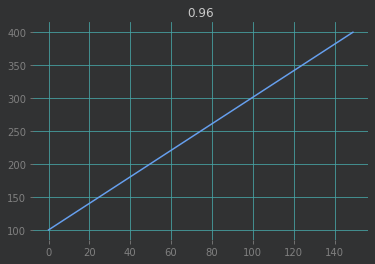

In [7]:
# Hurst Exponent
# It is a statistics that helps in understanding the TimeSeries
# 0.5<Hurst<1 -> Trending movement; 0.5 = Hurst -> Random Walk; 0<Hurst<0.5 -> Anti-persistent movement

# compute Hurst Exponent
array = np.linspace(0, 300, 150) + 100
hurst = compute_Hc(array)
hurst[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst[0]}")
plt.show()

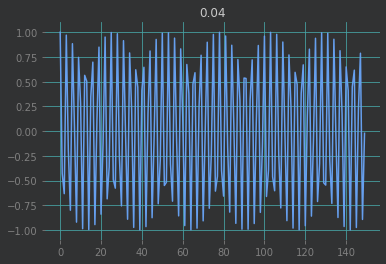

In [8]:
# Anti-persistent
array = np.cos(np.linspace(0,300,150))
hurst = compute_Hc(array)
hurst[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst[0]}")
plt.show()

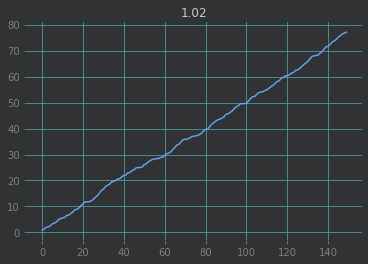

In [9]:
# Random Walk
np.random.seed(56)
array = np.cumsum(np.random.rand(150))
hurst = compute_Hc(array)[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst}")
plt.show()

In [10]:
# using Names CSV file find the best asset
asset = pd.read_csv('Names.csv')['Symbol']

# Initialize the list
Statistics = []
col = []
asset = ['GOOG',
		 'TCOM',
		 'INCY']
for fin in tqdm(asset):
	# check using yfinance
	try:
		print(fin)

		# Download the data of fin
		dataa = yf.download(fin).dropna()
		# Create a list of the statistics
		statistics = list()
		statistics.append(compute_Hc(dataa['Adj Close'])[0])  # Hurst Exponent
		statistics.append(np.sqrt(252) * dataa['Adj Close'].pct_change(1).dropna().std())  # volatility

		statistics.append(beta_function(dataa["Adj Close"].pct_change(1).dropna()))  # beta

		statistics.append(rsi(dataa, 5, 14).mean() * 252)  # RSI
		Statistics.append(statistics)
		col.append(fin)
	except Exception as e:
		pass

# Create dataframe with all statistics
dataframe = pd.DataFrame(Statistics, columns=['Hurst', 'Volatility', 'Beta', 'RSI'], index=col)
print(col, Statistics)
dataframe


  0%|          | 0/3 [00:00<?, ?it/s]

GOOG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 1/3 [00:03<00:06,  3.41s/it]


TCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 2/3 [00:06<00:03,  3.05s/it]


INCY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


['GOOG', 'TCOM', 'INCY'] [[0.6301474404886259, 0.25985762898041775, 1.3234059690477893, -0.023280597941158696], [0.5257236211600844, 0.5057961498412022, 1.7018923407733189, 0.02797588803939288], [0.5077894277572599, 0.663046936552017, 1.9605979149140609, 0.13913198838563748]]


,Hurst,Volatility,Beta,RSI
GOOG,0.630147,0.259858,1.323406,-0.023281
TCOM,0.525724,0.505796,1.701892,0.027976
INCY,0.507789,0.663047,1.960598,0.139132


In [11]:
# Extract the class of the asset
cluster = pd.read_csv('Names.csv',index_col='Symbol')
del cluster['Unnamed: 0']
cluster

,dummy
Symbol,
EURUSD=X,Currency
EURGBP=X,Currency
EURCHF=X,Currency
EURCAD=X,Currency
EURCNY=X,Currency
...,...
TCOM,Asset
INCY,Asset
CHKP,Asset


In [13]:
# Concat the type of asset and the statistics
dataframe = pd.concat([cluster,dataframe],axis=1).dropna()
dataframe

,dummy,Hurst,Volatility,Beta,RSI
GOOG,Asset,0.630147,0.259858,1.323406,-0.023281
TCOM,Asset,0.525724,0.505796,1.701892,0.027976
INCY,Asset,0.507789,0.663047,1.960598,0.139132
